<a href="https://colab.research.google.com/github/stoianmihail/HyperTone/blob/main/HyperTone-train-with-more-input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json
import os

DB_EPS = 1e-6
EPS = 1e-9

In [2]:
def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append({'path': os.path.join(root,file), 'data' : None})
  return ret

In [69]:
hypertone_dir = '/content/drive/MyDrive/hypertone/'
preprocessing_dir = hypertone_dir + 'preprocessing/'
model_dir = hypertone_dir + 'model/'
model_file = hypertone_dir + 'model/model.h5'
input_directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : input_directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [68]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [72]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[1]['files']

[{'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a'},
 {'data': 

In [73]:
kTones = 8
kBinsPerOctave = 24

# Corresponds to a jump from Pa -> Ga
kJump = int(4/3 * kBinsPerOctave)

fmin = librosa.midi_to_hz(36) # C2 (Ison)
fmax = librosa.midi_to_hz(84) # C6 (highest note ever seen in byzantine sheets: A5#)
print(fmin)
print(fmax)

65.40639132514966
1046.5022612023945


In [76]:
filename=tones[1]['files'][0]['path']
print(filename)
ipd.Audio(filename)

/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a


In [77]:
import math

def find_bin(f):
# Find which bin `f` fits into.
# The bins are geometrically distributed.
# Formula: 2**(i/`kBinsPerOctave`) * fmin
# Source: https://en.wikipedia.org/wiki/Constant-Q_transform
  return int(round(math.log2(f / fmin) * kBinsPerOctave)) if not math.isnan(f) else f

In [78]:
y, sr = librosa.load(filename)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax)
times = librosa.times_like(f0)
pyin_bins = list(map(find_bin, f0))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


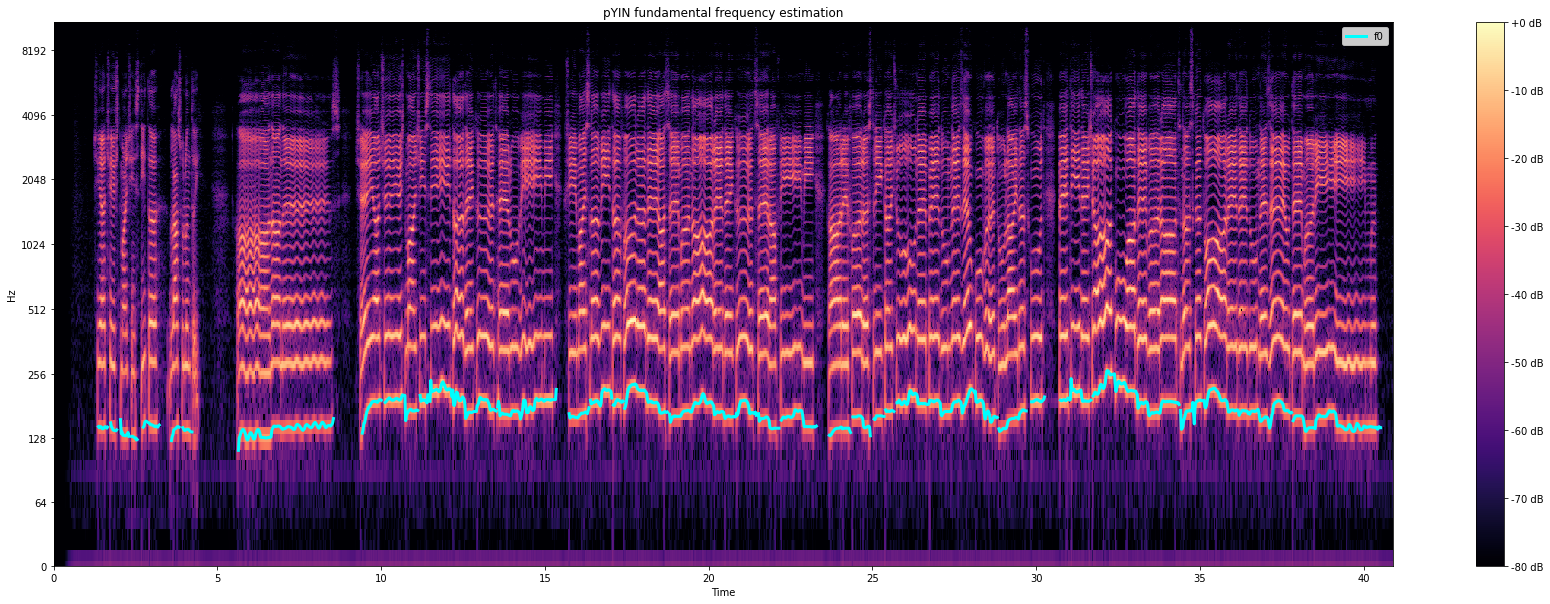

In [79]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(30, 10))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [81]:
def normalize_diffs(bins):
  pitch_diff = []
  last_index_non_nan = None
  for index, elem in enumerate(bins):
    # First position?
    if index == 0:
      continue
    # NaN?
    if math.isnan(elem):
      continue
    # No prev elem which is not NaN?
    if last_index_non_nan is None:
      last_index_non_nan = index
      continue
    diff = bins[index] - bins[last_index_non_nan]

    if abs(diff) > kJump:
      last_index_non_nan = index
      continue

    # isPositive = diff > 0
    # while abs(diff) > kJump and diff < 0:
    #   # `bins[last_index_non_nan]` >= `elem`.
    #   bins[index] += kBinsPerOctave
    #   diff = bins[index] - bins[last_index_non_nan]
      
    # while abs(diff) > kJump and diff > 0:
    #   # `bins[last_index_non_nan]` <= `elem`.
    #   pyin_bins[last_index_non_nan] += kBinsPerOctave
    #   diff = bins[index] - bins[last_index_non_nan]
    
    # Update
    last_index_non_nan = index
    pitch_diff.append(diff)
  return pitch_diff

In [84]:
def solve_audio(filepath):
  y_, sr_ = librosa.load(filename)
  f0_, voiced_flag_, voiced_probs_ = librosa.pyin(y_, fmin=fmin, fmax=fmax)
  bins = list(map(find_bin, f0))
  return [bins, normalize_diffs(bins)]

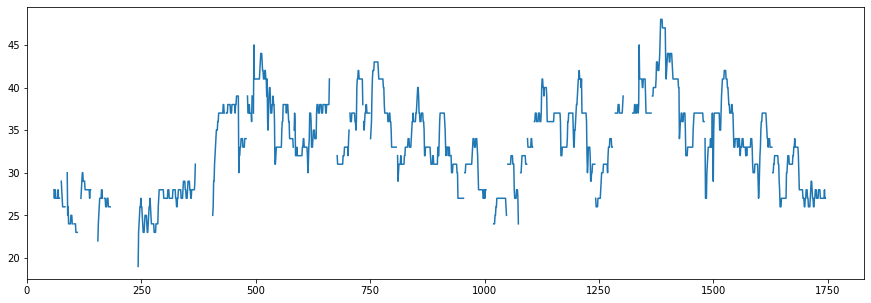

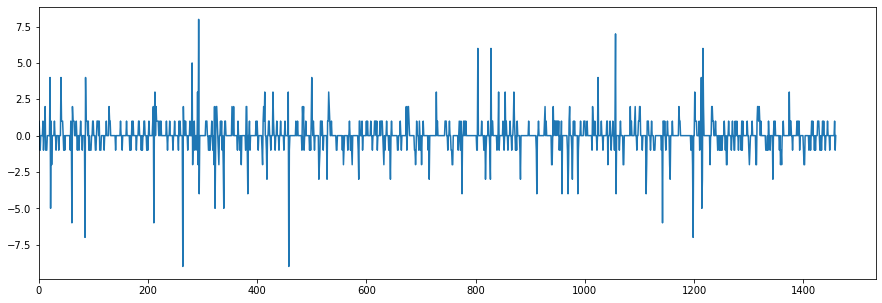

In [83]:
kPlotWidth = 15
plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(pyin_bins)
plt.xlim(xmin=0)
plt.show()

# print(find_bin(librosa.midi_to_hz(36)))
# print(find_bin(librosa.midi_to_hz(48)))

# bin_diffs = np.diff(pyin_bins)
# cleaned_bin_diffs = bin_diffs[np.logical_not(np.isnan(bin_diffs))]

# plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
# plt.plot(cleaned_bin_diffs)
# plt.xlim(xmin=0)
# plt.show()

custom_diffs = normalize_diffs(pyin_bins)

plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(custom_diffs)
plt.xlim(xmin=0)
plt.show()

In [ ]:
import os
import pickle

def prepare_data():
  print('Save tones..')
  acc = []
  for tone in tones:
    print('Tone: ' + str(tone))
    for index, file in enumerate(tones[tone]['files']):
      audio_name = os.path.basename(file['path']).replace('.m4a', '')
      print(f"Progress {1 + index} out of {len(tones[tone]['files'])}: Preprocessing {audio_name}")
      with open(preprocessing_dir + audio_name + '.pkl', 'wb') as f:
        pickle.dump(solve_audio(file['path']), f)
  pass

prepare_data()

In [102]:
import pickle
import pandas as pd

def compress(a):
  return a[np.logical_or(np.insert(np.diff(a).astype(bool), 0, True), np.asarray(a, dtype=bool))]

def parse_songs():
  songs = {}
  for file in get_files(preprocessing_dir):
    if '.pkl' not in file['path']:
      continue 
    song_name = os.path.basename(file['path']).replace('.pkl', '')
    x = pd.read_pickle(file['path'])
    compressed = compress(np.asarray(x[1]))
    
    # TODO: this is only for these recordings
    # TODO: Next time, also save the label!
    tone = 5
    if song_name[0].isdigit():
      tone = int(song_name[0])
    songs[song_name] = {'x': compressed, 'y': tone}
  return songs

songs = parse_songs()
print(songs['8.2 Troparele'])

{'x': array([-1,  1,  0, -1,  0,  1, -1,  0,  2, -1, -1, -1,  0,  4, -5,  1, -2,
        0,  1,  0, -1,  0, -1,  0,  4,  1,  1,  1,  0, -1,  0, -1,  0, -1,
        1,  0, -6,  2,  1,  1,  1,  0,  1,  0, -1,  0, -1,  0,  1,  0, -1,
        0, -7,  4,  1,  1,  1,  0,  1, -1,  0, -1, -1, -1,  0,  1,  1,  0,
       -1, -1,  0,  1,  1,  1,  0,  1, -1, -1, -1,  0, -1,  0,  1,  0,  2,
        1,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0, -1,  0, -1,  0,  1,  0,
        1,  0, -1,  0,  1,  1,  0, -1,  0, -1,  0,  1,  1,  0, -1,  0, -1,
        0,  1,  0,  1,  2, -6,  1,  3,  0,  2,  1,  1,  1,  1,  0,  1,  0,
        1,  0,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0, -1,  1,  0,  1,  0,
       -9,  2,  0,  1,  0,  1,  0, -1,  0,  1,  0,  5, -2,  0,  1, -1,  0,
       -1,  3, -2,  8, -4,  0,  1,  1,  1,  0, -1, -1,  0, -1,  0,  1,  0,
       -1,  0, -2,  2, -5, -1,  2,  2,  1,  0, -1, -2,  0,  1,  0,  1, -1,
        0, -2, -5,  0,  1,  1,  0,  2,  1,  0,  2,  0, -1,  1,  0, -1, -1,
        0, -2,  0, 

In [103]:
import tensorflow.keras as keras

# TODO: check the best one!
kSequenceLength = 128
kOutputUnits = 2 * kBinsPerOctave - 1
kNumUnits = [128, 64]
kLoss = "categorical_crossentropy"
kLearningRate = 0.001
kEpochs = 5
kBatchSize = 64

In [108]:
def generate_training_sequences(seq_len):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = parse_songs()

  inputs, targets = [], []
  for song in songs:
    x = songs[song]['x']
    y = songs[song]['y'] - 1
    #x[np.insert(np.diff(x).astype(np.bool), 0, True)]
    if len(x) < seq_len:
      x.resize(seq_len)
    num_sequences = len(x) - seq_len + 1
    for index in range(num_sequences):
      inputs.append(x[index : index + seq_len])
      targets.append(y)

  # one-hot encode the sequences  
  # inputs size: (# of sequences, sequence length, max(diff))
  inputs = keras.utils.to_categorical(inputs, num_classes=kOutputUnits)
  print(inputs.shape)
  #n = len(inputs)
  #inputs = np.reshape(inputs, (n, seq_len, 1))
  # normalize input
  #inputs = inputs / float(kOutputUnits)
  
  targets = keras.utils.to_categorical(targets, num_classes=kTones)
  print(targets.shape)
  print(f"There are {len(inputs)} sequences.")
  return inputs, targets

In [109]:
print(generate_training_sequences(kSequenceLength))

(83664, 128, 47)
(83664, 8)
There are 83664 sequences.
(array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0.

In [110]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint

def build_model(shape, output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    #input = keras.layers.Input(shape=(None, output_units))
    #x = keras.layers.LSTM(num_units[0])(input)
    #x = keras.layers.LSTM(num_units[1])(x)
    #x = keras.layers.Dropout(0.2)(x)
    #output = keras.layers.Dense(kTones, activation="softmax")(x)
    #model = keras.Model(input, output)

    # compile model
    #model.compile(loss=loss,
    #              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #              metrics=["accuracy"])

    print(shape)

    model = Sequential()
    model.add(LSTM(
        num_units[0],
        input_shape=(shape[1], shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(num_units[1]))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(kTones))
    model.add(Activation('softmax'))
    model.compile(loss=kLoss, optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model

def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    # build the network
    model = build_model(inputs.shape, output_units, num_units, loss, learning_rate)

    filepath = model_dir + "all-weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    # train the model
    model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize, callbacks=callbacks_list)

    # save the model
    model.save(model_file)

In [ ]:
train()

(83664, 128, 47)
(83664, 8)
There are 83664 sequences.
(83664, 128, 47)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 128)          90112     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
Total params: 140,296
Trainable params: 140,168
No

In [ ]:
class HyperTone:
  """A class that wraps the LSTM model and offers utilities to generate melodies."""

  def __init__(self, path=model_file):
    """Constructor that initialises TensorFlow model"""
    self.model = keras.models.load_model(path)
  
  def extract_tones(self, x):
    # Pad, if necessary
    if len(x) < kSequenceLength:
      x.resize(kSequenceLength)

    y = []
    num_sequences = len(x) - kSequenceLength + 1
    print("num_sequences=" + str(num_sequences))
    for index in range(num_sequences):
      seed = x[index : index + kSequenceLength]

      #print(seed)

      # one-hot encode the seed
      onehot_seed = keras.utils.to_categorical(seed, num_classes=kOutputUnits)

      # (1, max_sequence_length, num of symbols in the vocabulary)
      onehot_seed = onehot_seed[np.newaxis, ...]


      #print(onehot_seed)

      # make a prediction
      probabilities = self.model.predict(onehot_seed)[0]
      #print(probabilities)
      index = self.sample(probabilities)
      y.append(1 + index)              
    return y

  def sample(self, probabilites, temperature=0.1):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [ ]:
f10 = tones[1]['files'][0]['path']
f11 = tones[1]['files'][2]['path']
f80 = tones[8]['files'][1]['path']
f81 = tones[8]['files'][4]['path']

In [ ]:
ipd.Audio(f11)

In [ ]:
ipd.Audio(f81)

In [ ]:
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(f10)))
print(ht.extract_tones(encode_audio(f11)))
print(ht.extract_tones(encode_audio(f81)))
print(ht.extract_tones(encode_audio(f81)))

In [ ]:
test_filename = '/content/drive/MyDrive/hypertone/Utrenia_glas_1_Anastasimatar_Victor_Ojog/Anastasimatar Victor Ojog - Glasul I -  073 Dumnezeu este Domnul paralaghie.mp3'
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(test_filename)))